# *Notebook Computer Vision*

## Sommaire

<ol>
    <li><a href="#">Import des librairies</a></li>
    <li><a href="#">Chargement des données</a></li>
    <li><a href="#">Analyse des photos</a></li>
    <li><a href="#">Exemple d'extractions de features</a></li>
        <ol>
            <li><a href="#">Traitement de l'image</a></li>
            <li><a href="#">Extraction des features</a></li>
        </ol>
    <li><a href="#">Extraction de features sur toutes les images</a></li>
        <ol>
            <li><a href="#">Traitement des images et extraction des features avec SIFT</a></li>
            <li><a href="#">kMeans - clustering des descripteurs</a></li>
            <li><a href="#">ACP</a></li>
            <li><a href="#">TSNE</a></li>
            <li><a href="#">kMeans - clustering des images en 2 dimensions</a></li>
        </ol>
    <li><a href="#">Utilisation d'un CNN (Réseau de neurones convolutif)</a></li>
        <ol>
            <li><a href="#">Exemple avec l'algo VGG16</a></li>
            <li><a href="#">Extraction de features</a></li>
            <li><a href="#">Transfer Learning</a></li>
        </ol>
</ol>

## Import des librairies

In [283]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import pandas as pd
from PIL import Image

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn import cluster, metrics
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf

import cv2

from keras.layers import Dense, Flatten
from keras import Model
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing.image import load_img, img_to_array
from keras.applications.vgg16 import decode_predictions

# Import des modules contenant les fonctions utilitaires
import src.data_helpers as dth

## Chargement des données

In [2]:
path_photos = 'data/yelp_photos/'

In [3]:
# Chargement du fichier json
photos_df = pd.read_json(path_photos + "photos.json", lines=True)

In [4]:
photos_df.head()

photo_id             business_id  \
0  zsvj7vloL4L5jhYyPIuVwg  Nk-SJhPlDBkAZvfsADtccA   
1  HCUdRJHHm_e0OCTlZetGLg  yVZtL5MmrpiivyCIrVkGgA   
2  vkr8T0scuJmGVvN2HJelEA  _ab50qdWOk0DdB6XOrBitw   
3  pve7D6NUrafHW3EAORubyw  SZU9c8V2GuREDN5KgyHFJw   
4  H52Er-uBg6rNrHcReWTD2w  Gzur0f0XMkrVxIwYJvOt2g   

                                             caption    label  
0  Nice rock artwork everywhere and craploads of ...   inside  
1                                                     outside  
2                                     oyster shooter    drink  
3                                      Shrimp scampi     food  
4                                                        food

In [5]:
photos_df.shape

(200100, 4)

In [134]:
labels = photos_df['label'].value_counts().index.tolist()
print(labels)

['food', 'inside', 'outside', 'drink', 'menu']


In [7]:
# On récupère 200 photos pour chaque label
list_photos = []
list_labels = []

for label in labels:
    sample_df = photos_df[photos_df['label'] == label].sample(200, random_state=42)
    list_photos.extend(sample_df['photo_id'])
    list_labels.extend(sample_df['label'])

len(list_photos)


1000

## Analyse des photos

Exemple d'images pour le label : food


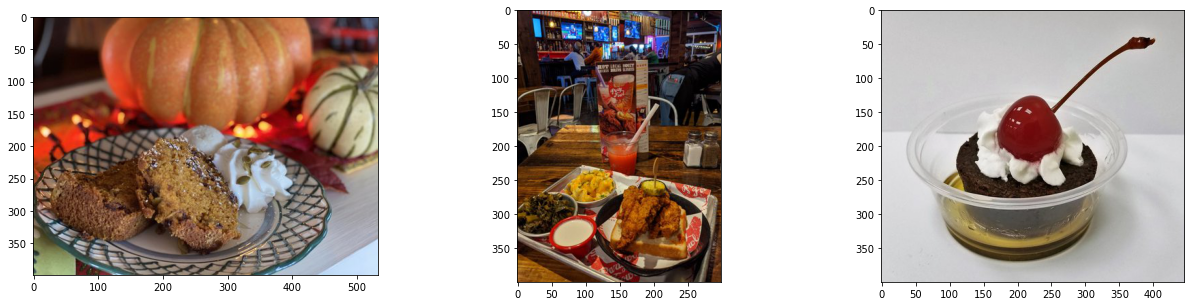

Exemple d'images pour le label : inside


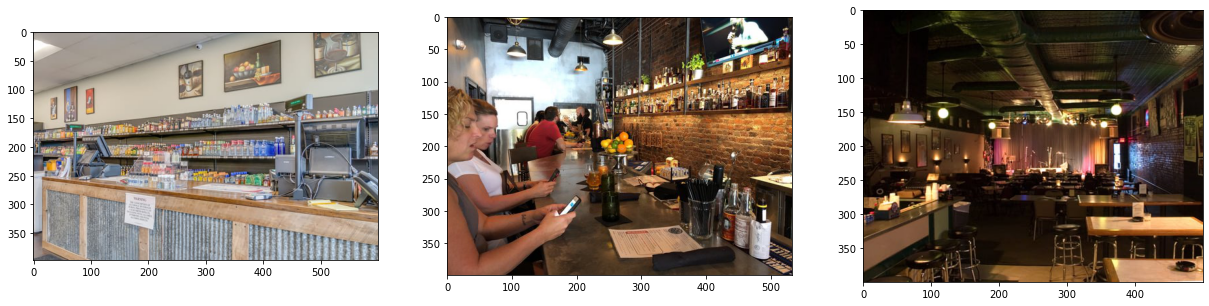

Exemple d'images pour le label : outside


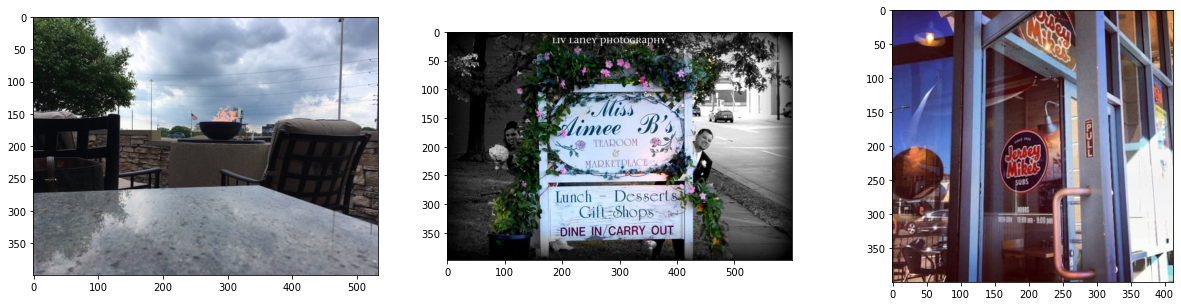

Exemple d'images pour le label : drink


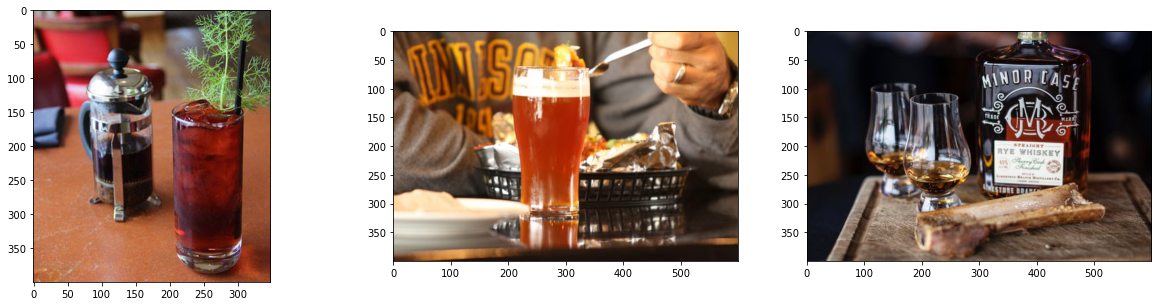

Exemple d'images pour le label : menu


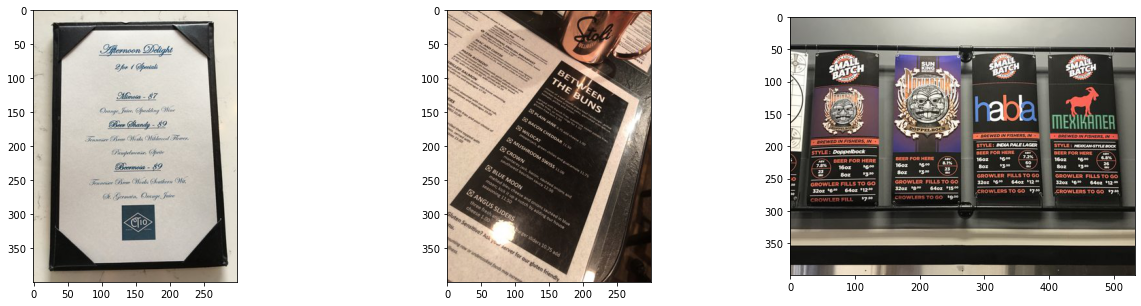

In [8]:
# Affiche 3 images en exemple pour chaque label
for i in range(5):
    print(f"Exemple d'images pour le label : {labels[i]}")
    plt.subplots(1, 3, figsize=(21,5))
    for j in range(3):
        img = Image.open(path_photos + "photos/" + list_photos[i*200+j+3] + ".jpg")
        # Afficher l'image
        plt.subplot(1, 3, j+1)
        plt.imshow(img)
    plt.show()

In [9]:
img = Image.open(path_photos + "photos/" + list_photos[7] + ".jpg")

In [10]:
# Récupérer et afficher la taille de l'image (en pixels)
w, h = img.size
print(f"Largeur : {w} px, hauteur : {h} px")

# Afficher son mode de quantification
print(f"Format des pixels : {img.mode}")

# Récupérer et afficher la valeur du pixel à une position précise
px_value = img.getpixel((20,100))
print(f"Valeur du pixel situé en (20,100) : {px_value}")

Largeur : 600 px, hauteur : 399 px
Format des pixels : RGB
Valeur du pixel situé en (20,100) : (5, 1, 0)


## Exemple d'extractions de features

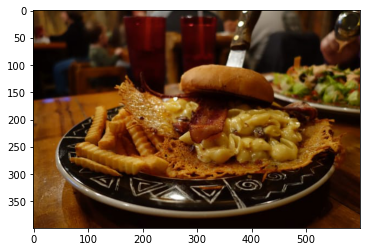

In [11]:
# Afficher l'image
plt.imshow(img)
plt.show()

### Traitement de l'image

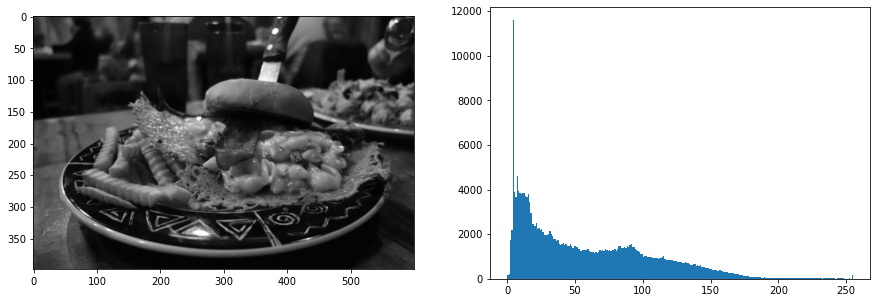

In [12]:
# On convertit notre image en noir et blanc, et on affiche l'histogramme de son niveau de gris
image = cv2.imread(path_photos + "photos/" + list_photos[7] + ".jpg", 0)
dth.show_image_hist(image)


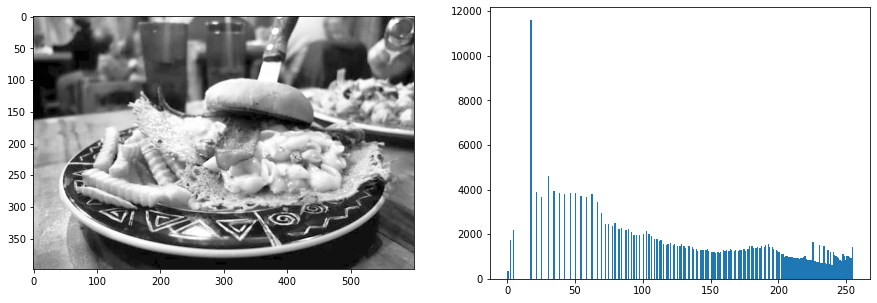

In [13]:
# On corrige la luminosité (ou exposition) et le contraste, en étirant son histogramme puis en l'égalisant
image = cv2.equalizeHist(image)
dth.show_image_hist(image)

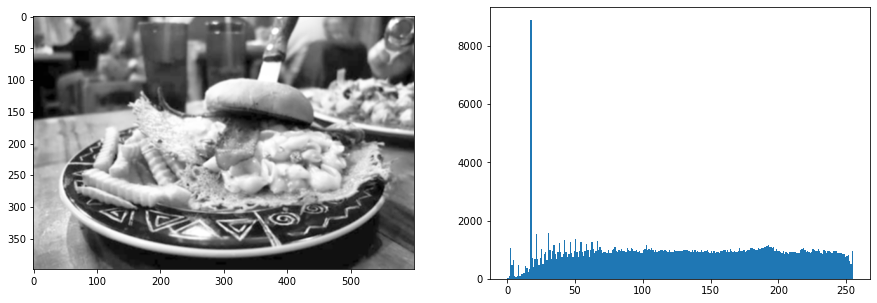

In [14]:
# On élimine le bruit, en contrepartie l'image sera floue
image = cv2.blur(image, (3,3)) # Filter blur image
dth.show_image_hist(image)

### Extraction des features

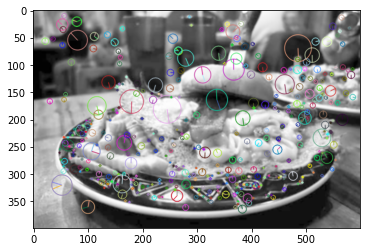

In [99]:
# Exemple d'extraction de features sur cette image avec SIFT
sift = cv2.SIFT_create(nfeatures=500)
kp, des = sift.detectAndCompute(image,None)

img2=cv2.drawKeypoints(image,kp,image, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

plt.imshow(img2)
plt.show()

La **scale-invariant feature transform (SIFT)** est un algorithme utilisé pour détecter et identifier les éléments similaires entre différentes images numériques.

Il convient de traiter l'image avant d'utiliser l'algorithme SIFT, il s'agit en fait de normaliser son niveau de gris pour corriger la luminosité, le contraste, puis éliminer l'éventuel bruit, ce qui floutera un peu l'image mais ce n'est pas gênant pour l'extraction des features.

L'algorithme SIFT va ensuite calculer des descripteurs (fixés à 500 dans notre cas), qui sont des caractéristiques du contenu visuel de l'image, indépendamment du zoom, du cadrage, de l'angle de vision ..

Ainsi, des photographies d'un même objet auront toutes les chances d'avoir des descripteurs SIFT similaires.

## Extractions de features sur toutes les images

On va donc réutiliser la technique de traitement et l'algorithme SIFT de l'exemple précédent, pour l'appliquer à tout notre échantillon d'images.

In [100]:
# Algorithme SIFT calculant 500 descripteurs par image
sift = cv2.SIFT_create(nfeatures=500)

### Traitement des images et extraction des features avec SIFT

In [101]:
# On traite les images et on calcule les 500 descripteurs pour chacune
# Les descripteurs de chaque image sont ensuite ajoutés dans un tableau
sift_keypoints = []

for photo in list_photos:
    kp, des = dth.transform_image(path_photos + "photos/" + photo + ".jpg", sift)
    sift_keypoints.append(des)

In [102]:
# On aligne les 500 descripteurs par image pour faire une liste unique de descripteur
sift_keypoints_all = np.concatenate(sift_keypoints, axis=0)
print()
print("Nombre de descripteurs : ", sift_keypoints_all.shape)


Nombre de descripteurs :  (483227, 128)


### kMeans - clustering des descripteurs

On a calculé 500 descripteurs pour chaque image.

On va maintenant utiliser l'algorithme kMeans pour clusteriser la totalité des descripteurs.

In [120]:
k = int(round(np.sqrt(len(sift_keypoints_all)),0))
print("Nombre de clusters estimés : ", k)
print("Création de",k, "clusters de descripteurs ...")

kmeans = cluster.MiniBatchKMeans(n_clusters=k)
kmeans.fit(sift_keypoints_all)

Nombre de clusters estimés :  695
Création de 695 clusters de descripteurs ...


C:\DEV\.env\anaconda3\envs\projet_ml\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(


MiniBatchKMeans(n_clusters=695)

In [121]:
def build_histogram(kmeans, des, image_num):
    res = kmeans.predict(des)
    hist = np.zeros(len(kmeans.cluster_centers_))
    nb_des = len(des)
    if nb_des==0 : print(f"L'image n°{image_num} n'a pas de descripteurs")
    for i in res:
        hist[i] += 1.0/nb_des # pondération par rapport au nombre de descripteur
    return hist


# Création d'une matrice d'histogrammes
hist_vectors=[]

for i, image_desc in enumerate(sift_keypoints) :
    hist = build_histogram(kmeans, image_desc, i)
    hist_vectors.append(hist)

im_features = np.asarray(hist_vectors)

Chaque histogramme d'une image représente un pourcentage d'appartenance des ses descripteurs à chaque cluster calculé par le kMeans précédent.

On va maintenant réduire le nombre de dimensions avec l'**ACP**, et on garde un nombre de dimensions de façon à avoir une variance expliquée à 99%.

### ACP

In [194]:
pca = PCA(n_components=0.99, random_state=42)
feat_pca = pca.fit_transform(im_features)
print("Dimensions dataset après réduction PCA : ", feat_pca.shape)

Dimensions dataset après réduction PCA :  (1000, 551)


On passe de 695 à 551 features avec l'ACP.

On va maintenant réduire l'espace de dimension avec l'algorithme **TSNE**, pour obtenir 2 dimensions et pouvoir visualiser sous forme de nuage de points les images et leur label associé.

### TSNE

In [195]:
tsne = TSNE(n_components=2,n_iter=1000,perplexity=30)

X_tsne = tsne.fit_transform(feat_pca)

df_tsne = pd.DataFrame(X_tsne, columns=['tsne1', 'tsne2'])
df_tsne["class"] = list_labels
print(df_tsne.shape)

C:\DEV\.env\anaconda3\envs\projet_ml\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\DEV\.env\anaconda3\envs\projet_ml\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


(1000, 3)


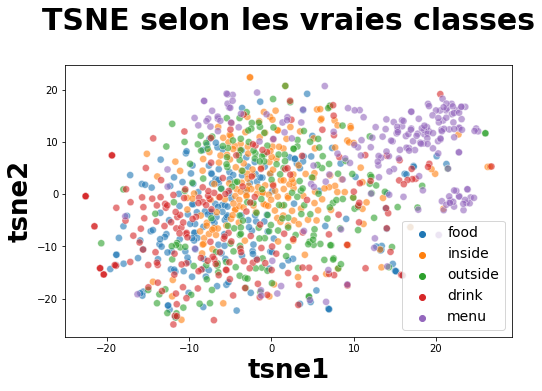

In [196]:
plt.figure(figsize=(8,5))
sns.scatterplot(
    x="tsne1", y="tsne2", hue="class", data=df_tsne, legend="brief",
    palette=sns.color_palette('tab10', n_colors=5), s=50, alpha=0.6)

plt.title('TSNE selon les vraies classes', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 14}) 

plt.show()

On voit que "menu' se distingue des autres clasess. "food" et "drink" se retrouvent ensemble ainsi que "inside" et "outside".

La distinction est tout de même difficile à effectuer.

On va maintenant clusteriser ces données en 2 dimensions avec l'algorithme kMeans, et comparer le résultat avec les vraies classes.

### kMeans - clustering des images en 2 dimensions

In [197]:

n_cluster = len(labels)
cls = cluster.KMeans(n_clusters=n_cluster, random_state=42)
cls.fit(X_tsne)

df_tsne["cluster"] = cls.labels_
print(df_tsne.shape)

(1000, 4)


In [198]:
df_tsne["cluster"].value_counts()

2    239
4    222
1    194
0    174
3    171
Name: cluster, dtype: int64

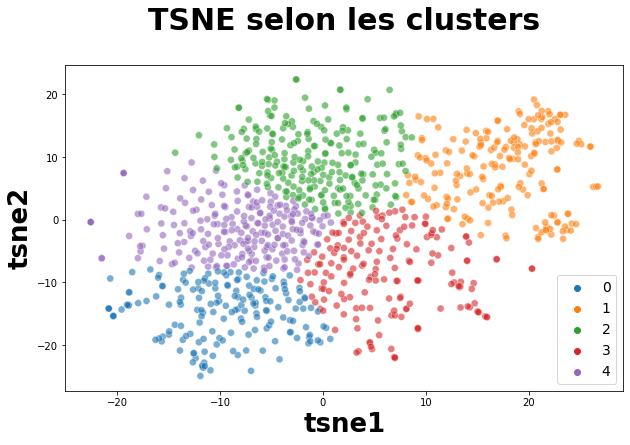

In [199]:
plt.figure(figsize=(10,6))
sns.scatterplot(
    x="tsne1", y="tsne2",
    hue="cluster",
    palette=sns.color_palette('tab10', n_colors=n_cluster), s=50, alpha=0.6,
    data=df_tsne,
    legend="brief")

plt.title('TSNE selon les clusters', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 14}) 

plt.show()

In [200]:
print("ARI : ", metrics.adjusted_rand_score(df_tsne['class'], df_tsne['cluster']))

ARI :  0.12566638280464393


En comparant le clustering sur les données à basse dimensions avec les vraies classes, on obtient un **ARI score de 0.125**, ce qui est relativement peu.

Le score n'est pas très élevé car les images ont été traitées avant l'utilisation de l'algo SIFT, et l'extraction de features ne permet pas d'extraire d'élement caractéristique pertinent dans chaque image.

## Utilisation d'un CNN (Réseau de neurones convolutif)

On va essayer d'obtenir un score plus important en utilisant cette fois ci un Réseau de neurones convolutif (CNN).

Les réseaux de neurones convolutifs désignent une sous-catégorie de réseaux de neurones. Les CNN sont spécialement conçus pour traiter des images en entrée.

### Exemple avec l'algo VGG16

On va utiliser l'algorithme pré entraîné VGG16, qui permet de classifier une image parmis 1000 classes. 

Cet algortihme a été entraîné sur un échantillon de millions d'images provenant d'ImageNet.

Voici la représentation 3D de son architecture, on y voit les différentes couches.

![vgg16.png](data/img/vgg16.png)

Comme exemple d'utilisation de cet algortihme, on va récupérer une image pour voir comment celle ci est classifiée.

In [96]:
model = VGG16()

# La taille de l’image d’entrée par défaut de VGG-16 est de 224×224. On redimensionne donc notre image.
img = load_img(path_photos + "photos/" + photos_df.iloc[6]['photo_id'] + ".jpg", target_size=(224, 224))

# On convertit notre image en matrice de pixels.
test_img = img_to_array(img)

# La dimension de l’image d’entrée par défaut de VGG16 est (None,224,224,3), on ajoute donc une autre dimension a notre matrice.
test_img = test_img.reshape((1, test_img.shape[0], test_img.shape[1], test_img.shape[2]))

# Traiter les pixels de l’image de la même manière que les données d’entraînement d’ImageNet ont été préparées.
test_img = preprocess_input(test_img)

prediction = model.predict(test_img)

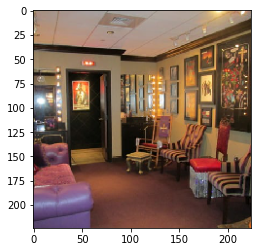

In [97]:
# Afficher l'image
plt.imshow(img)
plt.show()

In [98]:
labels = decode_predictions(prediction)
print('%s (%.2f%%)' % (labels[0][0][1], labels[0][0][2]*100))
print('%s (%.2f%%)' % (labels[0][1][1], labels[0][1][2]*100))
print('%s (%.2f%%)' % (labels[0][2][1], labels[0][2][2]*100))

home_theater (54.80%)
cinema (15.96%)
restaurant (11.00%)


La classification est assez précise, et fournis un pourcentage de probabilité d'appartenance à plusieurs classes. Ici on a restaurant qui ressort avec 11%.

### Extraction de features

On va réutiliser cet algorithme VGG16 pré-entraîné, en désactivant simplement la couche top qui sert de classification, pour prédire les features à partir de nos images.

L'intérêt est ensuite de classifier via un kMeans les features obtenues et comparer avec les vraies classes, pour voir si l'on obient un meilleur ARI score qu'avec la méthode SIFT.

In [223]:
# Modèle VGG16 sans la couche top
model = VGG16(weights="imagenet", include_top=False)
model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [224]:
# Méthode pour traiter chaque image avant de la passer en entrée de l'algorithme
def preprocess_image(path):
    img = img_to_array(load_img(path_photos + "photos/" + path + ".jpg", target_size=(224, 224)))
    return preprocess_input(np.expand_dims(img, axis=0))

In [228]:
# On récupère dans une liste les features de chaque image calculée par notre modèle
vgg16_feature_list = []

for photo in list_photos:
    vgg16_feature = model.predict(preprocess_image(photo))
    vgg16_feature_np = np.array(vgg16_feature)
    vgg16_feature_list.append(vgg16_feature_np.flatten())

vgg16_feature_list_np = np.array(vgg16_feature_list)

In [233]:
vgg16_feature_list_np.shape

(1000, 25088)

On va maintenant réduire le nombre de dimensions avec l'**ACP**, et on garde un nombre de dimensions de façon à avoir une variance expliquée à 99%.

In [232]:
pca_vgg = PCA(n_components=0.99, random_state=42)
feat_pca_vgg = pca_vgg.fit_transform(vgg16_feature_list_np)
print("Dimensions dataset après réduction PCA : ", feat_pca_vgg.shape)

Dimensions dataset après réduction PCA :  (1000, 928)


On passe de 25088 à 928 features avec l'ACP.

On va maintenant réduire l'espace de dimension avec l'algorithme **TSNE**, pour obtenir 2 dimensions et pouvoir visualiser sous forme de nuage de points les images et leur label associé.

In [234]:
tsne_vgg = TSNE(n_components=2,n_iter=1000,perplexity=30)

X_tsne_vgg = tsne_vgg.fit_transform(feat_pca_vgg)

df_tsne_vgg = pd.DataFrame(X_tsne_vgg, columns=['tsne1', 'tsne2'])
df_tsne_vgg["class"] = list_labels
print(df_tsne_vgg.shape)

C:\DEV\.env\anaconda3\envs\projet_ml\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\DEV\.env\anaconda3\envs\projet_ml\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


(1000, 3)


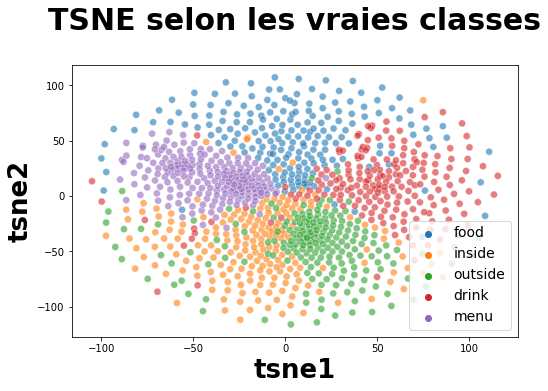

In [235]:
plt.figure(figsize=(8,5))
sns.scatterplot(
    x="tsne1", y="tsne2", hue="class", data=df_tsne_vgg, legend="brief",
    palette=sns.color_palette('tab10', n_colors=5), s=50, alpha=0.6)

plt.title('TSNE selon les vraies classes', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 14}) 

plt.show()

Cette fois ci, la classification est mieux réalisée qu'avec le SIFT. On distingue bien les 5 classes.

On va maintenant clusteriser ces données en 2 dimensions avec l'algorithme kMeans, et comparer le résultat avec les vraies classes.

In [236]:
n_cluster = len(labels)
cls_vgg = cluster.KMeans(n_clusters=n_cluster, random_state=42)
cls_vgg.fit(X_tsne_vgg)

df_tsne_vgg["cluster"] = cls_vgg.labels_
print(df_tsne_vgg.shape)

(1000, 4)


In [237]:
df_tsne_vgg["cluster"].value_counts()

4    251
2    245
1    177
0    172
3    155
Name: cluster, dtype: int64

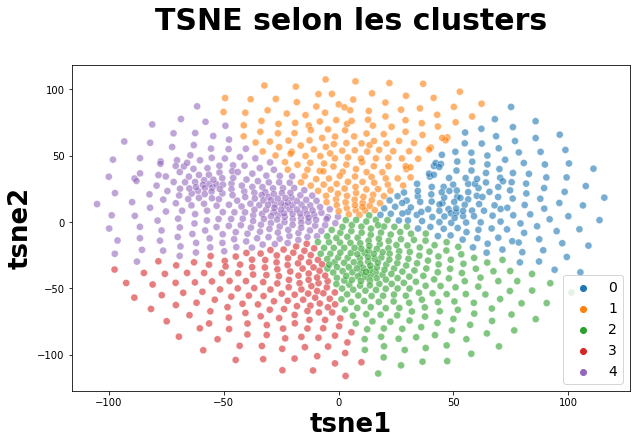

In [238]:
plt.figure(figsize=(10,6))
sns.scatterplot(
    x="tsne1", y="tsne2",
    hue="cluster",
    palette=sns.color_palette('tab10', n_colors=n_cluster), s=50, alpha=0.6,
    data=df_tsne_vgg,
    legend="brief")

plt.title('TSNE selon les clusters', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 14}) 

plt.show()

In [239]:
print("ARI : ", metrics.adjusted_rand_score(df_tsne_vgg['class'], df_tsne_vgg['cluster']))

ARI :  0.5429134875257299


On obtient un bien meilleur **ARI score** que précedemment. Il est ici de **0.54**

### Transfer Learning

Avec le transfer learning, ou apprentissage par transfert, on va ré-entraîner une partie du réseau sur les nouvelles classes (nos 5 classes), afin d'y faire par la suite une classification sur ces 5 classes plutôt que sur les 1000 classes du modèle pré-entraîné.

On va donc récupérer certaines couches du VGG16 que l'on va ré-entraîner.

In [262]:
# On récupère le modèle VGG16
vgg = VGG16(weights="imagenet", include_top=False, input_shape=(224,224,3), classes=5)
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [263]:
# On enlève les couches du modèle pré-entraîné
for layer in vgg.layers:
    layer.trainable = False

In [264]:
x = vgg.output
x = Flatten()(x)

# Ajouter la nouvelle couche fully-connected pour la classification à 5 classes
predictions = Dense(5, activation="softmax")(x)

In [265]:
# Définir le nouveau modèle
model = Model(inputs=vgg.input, outputs=predictions)

# Compiler le modèle
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [266]:
# Méthode pour traiter chaque image avant de la passer en entrée de l'algorithme
def preprocess_img(path):
    img = img_to_array(load_img(path_photos + "photos/" + path + ".jpg", target_size=(224, 224)))
    return preprocess_input(img)

In [267]:
def preprocess_label(label):
    dic = {
        "food":0,
        "inside":1,
        "outside":2,
        "drink":3,
        "menu":4
    }
    return dic[label]

In [268]:
X = np.asarray([preprocess_img(path) for path in list_photos])
y = np.asarray([preprocess_label(label) for label in list_labels])

In [269]:
# On sépare nos données en jeu de test et en jeu d'entraînement
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)
y_train = tf.keras.utils.to_categorical(y_train)
y_test = tf.keras.utils.to_categorical(y_test)

In [270]:
# Entraîner sur les données d'entraînement (X_train, y_train)
model_info = model.fit(X_train, y_train, epochs=8, batch_size=256)

Epoch 1/8
4/4 [==============================] - 147s 30s/step - loss: 13.3002 - accuracy: 0.4663
Epoch 2/8
4/4 [==============================] - 150s 34s/step - loss: 3.1888 - accuracy: 0.8825
Epoch 3/8
4/4 [==============================] - 147s 33s/step - loss: 0.4920 - accuracy: 0.9762
Epoch 4/8
4/4 [==============================] - 146s 33s/step - loss: 0.2610 - accuracy: 0.9825
Epoch 5/8
4/4 [==============================] - 146s 33s/step - loss: 0.0257 - accuracy: 0.9987
Epoch 6/8
4/4 [==============================] - 145s 33s/step - loss: 0.0018 - accuracy: 0.9987
Epoch 7/8
4/4 [==============================] - 145s 33s/step - loss: 9.8738e-04 - accuracy: 1.0000
Epoch 8/8
4/4 [==============================] - 144s 32s/step - loss: 4.8365e-05 - accuracy: 1.0000


In [271]:
# On évalue accuracy et loss sur le jeu de test
scores = model.evaluate(X_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

7/7 [==============================] - 30s 4s/step - loss: 4.9487 - accuracy: 0.8800
Test loss: 4.948733806610107
Test accuracy: 0.8799999952316284


On a une **précision** de **88%** ce qui est beaucoup plus que toutes les méthodes précédentes !

In [272]:
y_predicted = model.predict(X_test)

In [278]:
predicted_classes = np.argmax(y_predicted, axis=1)

true_classes = np.argmax(y_test,axis=1)

In [281]:
cm = confusion_matrix(true_classes,predicted_classes)

print(classification_report(true_classes, predicted_classes))


              precision    recall  f1-score   support

           0       0.97      0.94      0.95        33
           1       0.79      0.88      0.83        48
           2       0.77      0.92      0.84        37
           3       0.94      0.84      0.89        38
           4       1.00      0.84      0.91        44

    accuracy                           0.88       200
   macro avg       0.90      0.88      0.89       200
weighted avg       0.89      0.88      0.88       200



In [220]:
pd.DataFrame(cm,columns=labels,index=labels)

food  inside  outside  drink  menu
food       32       0        0      1     0
inside      1      40        5      2     0
outside     0       4       32      1     0
drink       3       2        0     33     0
menu        1       1        0      0    42

En utilisant l'aglorithme VGG16 ré-entraîné sur nos classes, on obient une très bonne précision, de l'ordre de 90%.

La matrice de confusion nous permet d'observer comment chaque image est prédite en fonction de sa vraie classe.